In [18]:
import logging
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pyrtid
import scipy as sp
from pyrtid.utils import NDArrayFloat

- Set-up logging level

In [19]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")

INFO:root:this is a logging test


- Check package/software versions


In [20]:
pyrtid.utils.show_versions()

INFO:root:Current version = 0.1.2

INFO:root:Used packages version:

INFO:root:iterative_ensemble_smoother = 0.1.1
INFO:root:gstools                     = 1.5.1
INFO:root:matplotlib                  = 3.7.2
INFO:root:nested_grid_plotter         = 1.0.0
INFO:root:numdiftools                 = 0.9.41
INFO:root:numpy                       = 1.25.2
INFO:root:pyesmda                     = 0.4.3
INFO:root:pypcga                      = 0.1.0
INFO:root:scipy                       = 1.10.1
INFO:root:sksparse                    = 0.4.12
INFO:root:stochopy                    = 2.3.0


- Create a directory to store the exported figures

In [21]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [22]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    # "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

- Create an image with two circles for denoising

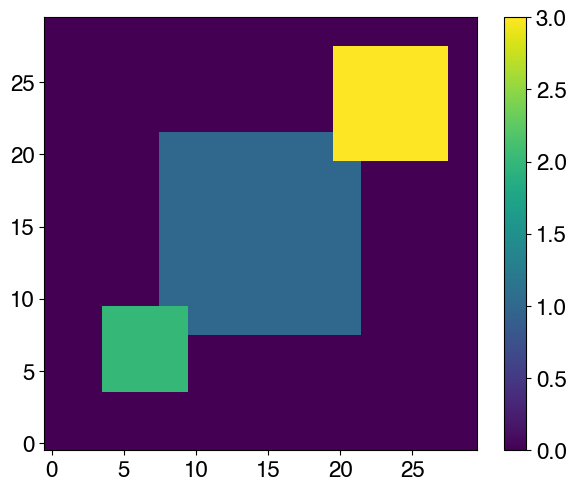

In [23]:
exact_data = np.zeros((30, 30))
exact_data[8:22, 8:22] = 1.0
exact_data[4:10, 4:10] = 2.0
exact_data[20:28, 20:28] = 3.0

plt.imshow(exact_data, origin="lower")
plt.colorbar()

In [24]:
noisy_data = exact_data + np.random.default_rng(2024).normal(
    loc=0.0, scale=0.5, size=(30, 30)
)

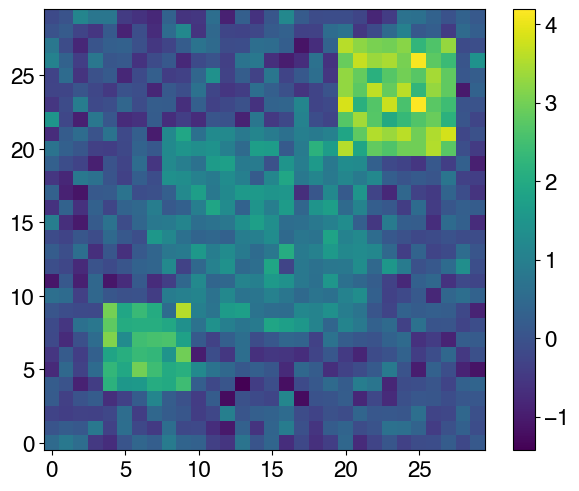

In [25]:
plt.imshow(noisy_data, origin="lower")
plt.colorbar()

- Define objective functions

In [26]:
def J_LS(s: NDArrayFloat) -> float:
    return 0.5 * float(np.sum((s - noisy_data.ravel()) ** 2))


reg = pyrtid.inverse.regularization.TVRegularizator(1.0, 1.0)


def loss_reg(s: NDArrayFloat) -> float:
    return reg.eval_loss(s.reshape(30, 30))


def J(s: NDArrayFloat, alpha: float) -> float:
    return J_LS(s) + alpha * loss_reg(s)


def dJ_LS(s: NDArrayFloat) -> NDArrayFloat:
    return s - noisy_data.ravel()


def dloss_reg(s: NDArrayFloat) -> NDArrayFloat:
    return reg.eval_loss_gradient(s.reshape(30, 30)).ravel()


def dJ(s: NDArrayFloat, alpha: float) -> NDArrayFloat:
    return dJ_LS(s) + alpha * dloss_reg(s)

In [27]:
alphas = np.logspace(-2, 3, 50, base=10)
alphas

array([1.00000000e-02, 1.26485522e-02, 1.59985872e-02, 2.02358965e-02,
       2.55954792e-02, 3.23745754e-02, 4.09491506e-02, 5.17947468e-02,
       6.55128557e-02, 8.28642773e-02, 1.04811313e-01, 1.32571137e-01,
       1.67683294e-01, 2.12095089e-01, 2.68269580e-01, 3.39322177e-01,
       4.29193426e-01, 5.42867544e-01, 6.86648845e-01, 8.68511374e-01,
       1.09854114e+00, 1.38949549e+00, 1.75751062e+00, 2.22299648e+00,
       2.81176870e+00, 3.55648031e+00, 4.49843267e+00, 5.68986603e+00,
       7.19685673e+00, 9.10298178e+00, 1.15139540e+01, 1.45634848e+01,
       1.84206997e+01, 2.32995181e+01, 2.94705170e+01, 3.72759372e+01,
       4.71486636e+01, 5.96362332e+01, 7.54312006e+01, 9.54095476e+01,
       1.20679264e+02, 1.52641797e+02, 1.93069773e+02, 2.44205309e+02,
       3.08884360e+02, 3.90693994e+02, 4.94171336e+02, 6.25055193e+02,
       7.90604321e+02, 1.00000000e+03])

In [28]:
res_x_list = []
J_LS_list = []
loss_reg_list = []
for alpha in alphas:

    def wrap_J(s: NDArrayFloat) -> float:
        return J(s, alpha)

    def wrap_dJ(s: NDArrayFloat) -> NDArrayFloat:
        return dJ(s, alpha)

    res_x_list.append(
        sp.optimize.minimize(
            method="l-bfgs-b", x0=noisy_data.ravel(), fun=wrap_J, jac=wrap_dJ
        ).x
    )
    J_LS_list.append(J_LS(res_x_list[-1]))
    loss_reg_list.append(loss_reg(res_x_list[-1]))

In [29]:
alphas[29]

9.102981779915218

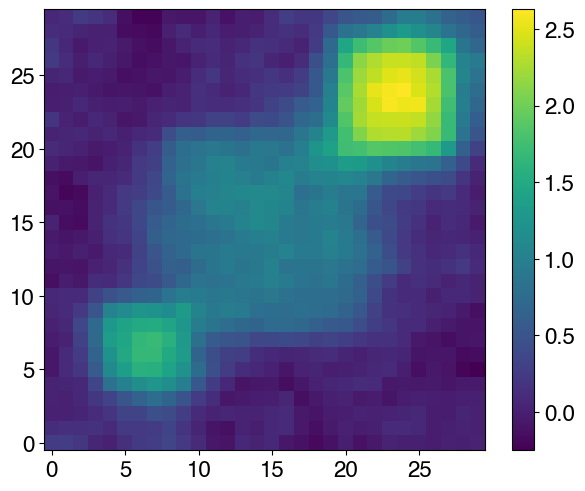

In [30]:
plt.imshow(res_x_list[32].reshape(30, 30), origin="lower")
plt.colorbar()

- Plot the L-curve

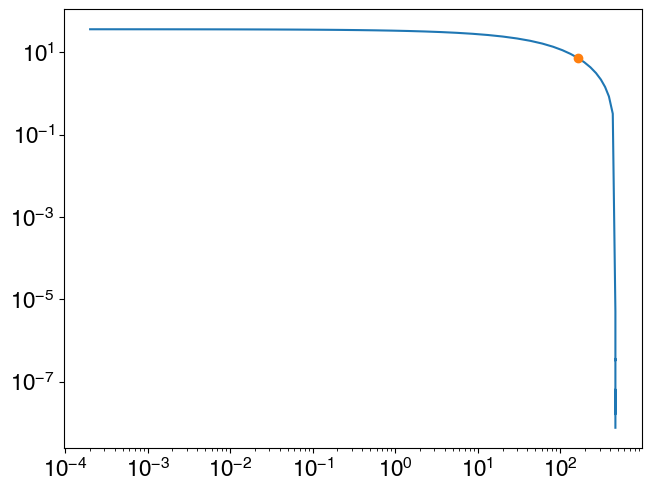

In [31]:
plt.loglog(J_LS_list, loss_reg_list)
plt.loglog(J_LS_list[32], loss_reg_list[32], marker="o")

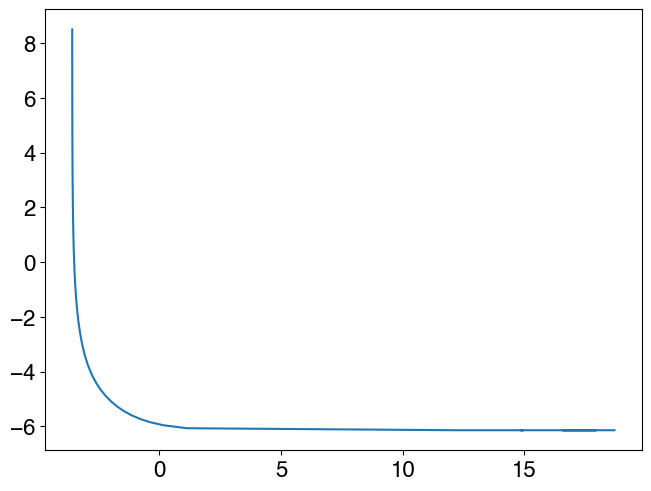

In [32]:
plt.plot(-np.log(loss_reg_list), -np.log(J_LS_list))

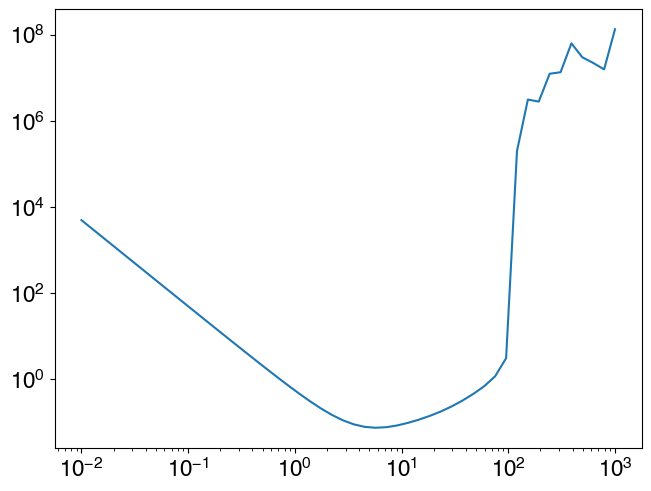

In [34]:
plt.loglog(alphas, 1 / np.array(J_LS_list) + 1 / np.array(loss_reg_list))